In [1]:
# Download packages
import pandas as pd
pd.set_option('display.max_columns',250)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from google.cloud import bigquery
# version conflict, needs to be google-cloud = 0.26.1

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from io import StringIO
from IPython.display import display
import os


In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '~/.config/gcloud/application_default_credentials.json'

In [4]:
credential_path = "/Users/audreychu/Desktop/projects/reddit/reddit AITA-55c7ff53d5ec.json"
# credential_path = "/home/jeremy/Desktop/projects/reddit/reddit AITA-2991631ea459.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

client = bigquery.Client()

In [5]:
# Query post data

QUERY = (""" SELECT * FROM fh-bigquery.reddit_posts.2019_08 WHERE subreddit = 'AmItheAsshole' and score > 10 and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_07`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2 

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_06`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_05`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_04`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_03`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_02`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_01`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_12`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_11`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_10`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_09`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
    """)


In [6]:
# API request
query_job = client.query(QUERY)

In [8]:
# Waits for query to finish
rows = query_job.result()
#for row in rows:
#    print(row.name)
df = query_job.to_dataframe()
df.shape

(39354, 33)

In [9]:
df.to_pickle('reddit_aita_2019_08.pickle')

In [10]:
df = pd.read_pickle('reddit_aita_2019_08.pickle')

In [11]:
df['title_length'] = [len(x.split()) for x in df['title']]
df['post_length'] = [len(x.split()) for x in df['selftext']]

In [12]:
df.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length
0,1539012283,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,22,31,None,None,AITA for going out of my way to avoid a disabl...,[deleted],None,9mft0t,None,0,None,False,1542574300,False,default,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/9mft0t/aita_for_goin...,None,None,False,not the a-hole,None,12,1
1,1540096028,AmItheAsshole,Pareogo,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,24,21,None,None,AITA? Did I make a racist joke?,"Ok, so I’ve been wanting to get this off my ch...",None,9q0u0k,None,0,None,False,1542634853,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/9q0u0k/aita_did_i_ma...,None,None,False,Asshole-ish,None,7,285
2,1536624485,AmItheAsshole,MyBigMessyCryFace,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,24,18,None,None,AITA because I didn’t want to talk about being...,**UPDATE: I’ve realised that the molestation w...,None,9esixs,None,0,None,False,1540105571,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/9esixs/aita_because_...,None,None,False,not the a-hole,None,10,959
3,1539231111,AmItheAsshole,Cxxcxc214,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,70,34,None,None,AITA for vaping THC and getting high in my room?,"I work part time, school full time. I am 20 ye...",None,9n6or7,None,0,None,False,1542586848,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/9n6or7/aita_for_vapi...,None,None,False,not the a-hole,None,10,227
4,1537793324,AmItheAsshole,MalgrugrousStudent,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,72,124,None,None,AITA For not wanting a mum with a pram taking ...,I take a train in the morning everyday. I take...,None,9ihmjw,None,0,None,False,1540167917,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/9ihmjw/aita_for_not_...,None,None,False,asshole,None,18,303


In [51]:
# these stats are only for posts with at least 10 net upvotes and 2 comments as per data pull
# Audrey to change what is pulled
df.describe()

,created_utc,num_comments,score,gilded,retrieved_on,title_length,post_length
count,3.935400e+04,39354.000000,39354.000000,39354.000000,3.935400e+04,39354.000000,39354.000000
mean,1.557060e+09,145.459674,581.060832,0.017254,1.561065e+09,12.709737,258.386339
std,7.116522e+06,390.783393,2508.130847,0.214657,6.426437e+06,5.134729,223.506395
min,1.535763e+09,3.000000,11.000000,0.000000,1.540057e+09,1.000000,0.000000
25%,1.552461e+09,25.000000,17.000000,0.000000,1.560187e+09,9.000000,1.000000
50%,1.558113e+09,44.000000,39.000000,0.000000,1.560953e+09,12.000000,241.000000
75%,1.563108e+09,102.000000,175.000000,0.000000,1.566722e+09,15.000000,407.000000
max,1.567295e+09,10655.000000,66384.000000,20.000000,1.567381e+09,64.000000,2666.000000


In [52]:
len(df)

39354

In [ ]:
# Query comment data

QUERY = (""" SELECT * FROM fh-bigquery.reddit_comments.2019_08 WHERE subreddit = 'AmItheAsshole'

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_07`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2 

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_06`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_05`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_04`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_03`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_02`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_01`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_12`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_11`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_10`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_09`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
    """)


In [13]:
# Query comment data

QUERY_com = (""" SELECT * FROM fh-bigquery.reddit_comments.2019_08 WHERE subreddit = 'AmItheAsshole'

    """)


In [14]:
# API request
query_job_com = client.query(QUERY_com)

# Waits for query to finish
rows_com = query_job_com.result()
#for row in rows:
#    print(row.name)
df_com = query_job_com.to_dataframe()
df_com.shape

(1454892, 20)

In [15]:
df_com.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
0,Yeah I don’t think OP did anything wrong and h...,None,None,None,vanyali,None,None,1564790667,t5_2xhvq,t3_cl3e85,t1_evubf8c,2,1573497810,0,0,evubimr,AmItheAsshole,None,None,None
1,Nta and this story will need a follow up. Too ...,None,None,None,Ilurkthecorners,None,None,1564790813,t5_2xhvq,t3_cl8kbt,t3_cl8kbt,1,1573497903,0,0,evubpk1,AmItheAsshole,None,None,None
2,"""just an excuse for her to be mad at me""??? WT...",None,None,None,kiwimaple,Asshole Enthusiast [5],None,1564790890,t5_2xhvq,t3_clbe7w,t1_evu7oeq,19,1573497951,0,0,evubt2j,AmItheAsshole,None,None,None
3,NTA and my new idol. Fuck yeah throw his tooth...,None,None,None,FYAGTHPATY,None,None,1564790906,t5_2xhvq,t3_cl66r6,t3_cl66r6,1,1573497960,0,0,evubtts,AmItheAsshole,None,None,None
4,\nIf you want your comment to count toward jud...,None,None,None,AutoModerator,Automation Enthusiast,None,1564790933,t5_2xhvq,t3_clc1ha,t3_clc1ha,1,1573497976,0,0,evubv4a,AmItheAsshole,None,moderator,None


In [35]:
# link_id is the matching key here
df_com.link_id.value_counts()

t3_cw43oc    9351
t3_cqin60    7626
t3_cm0bft    7528
t3_cvlkut    6629
t3_cn7li5    5812
             ... 
t3_cqywaf       1
t3_cwp738       1
t3_coc0uv       1
t3_co7q4o       1
t3_csomlh       1
Name: link_id, Length: 35910, dtype: int64

In [47]:
# Add post_id column to match with posts df
df_com['post_id'] = df_com['link_id'].str.split('_',1).str[1]

In [72]:
# lets view all views for one post
tamale_com = df_com[df_com['post_id']==df_com.post_id.iloc[0]]
tamale_com.loc[tamale_com['score'].idxmax()]

body                      NTA, but don't participate in any other work e...
score_hidden                                                           None
archived                                                               None
name                                                                   None
author                                                     godrestsinreason
author_flair_text                              Supreme Court Just-ass [123]
downs                                                                  None
created_utc                                                      1564748787
subreddit_id                                                       t5_2xhvq
link_id                                                           t3_cl3e85
parent_id                                                         t3_cl3e85
score                                                                  7631
retrieved_on                                                     1573467667
controversia

In [68]:
# lets look at the post linked to these comments
df.loc[df['id']==df_com.post_id.iloc[0],'url'].iloc[0]

# max score is indeed the top comment

'https://www.reddit.com/r/AmItheAsshole/comments/cl3e85/aita_for_bringing_van_tamales_to_a_potluck/'

In [74]:
# check flair is correct
df.loc[df['id']==df_com.post_id.iloc[0],'link_flair_text'].iloc[0]

'Not the A-hole'

In [75]:
# we pulled the comments to get the score since score associated with posts df refers
# the actual post. Lets see the difference
df.loc[df['id']==df_com.post_id.iloc[0],'score'].iloc[0]

4475

### Lets iterate and bring comment score into posts dataframe. We are only considered with max score by post in the comment dataframe.

In [91]:
# subset comment df for max score
com_score = pd.DataFrame(df_com.groupby(['post_id'])['score'].max().reset_index())
com_score.columns = ['id','com_score']

In [90]:
# merge com_score into post df
df = pd.merge(df,com_score,how="left",on='id')
df['com_score'].value_counts()

1.0        854
2.0        146
19.0        62
25.0        59
22.0        58
          ... 
15940.0      1
530.0        1
861.0        1
1565.0       1
1779.0       1
Name: com_score, Length: 1706, dtype: int64

In [96]:
# Try iterating
# Query comment data

QUERY_com = (""" SELECT 
    body
    , author
    , author_flair_text
    , link_id
    , score
    FROM fh-bigquery.reddit_comments.2019_08 
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score
    FROM `fh-bigquery.reddit_comments.2019_07`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2019_06`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2019_05`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2019_04`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2019_03`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2019_02`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2019_01`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2018_12`
    WHERE subreddit = 'AmItheAsshole'

    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2018_11`
    WHERE subreddit = 'AmItheAsshole'
    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2018_10`
    WHERE subreddit = 'AmItheAsshole'
    UNION DISTINCT

    SELECT body
    , author
    , author_flair_text
    , link_id
    , score 
    FROM `fh-bigquery.reddit_comments.2018_09`
    WHERE subreddit = 'AmItheAsshole'
    """)

In [97]:
# API request
query_job_com = client.query(QUERY_com)

# Waits for query to finish
rows_com = query_job_com.result()
#for row in rows:
#    print(row.name)
df_com = query_job_com.to_dataframe()
df_com.shape

(8074344, 5)

In [ ]:
df_com.to_pickle('reddit_aita_com_2019_08.pickle')

In [ ]:
df_com = pd.read_pickle('reddit_aita_com_2019_08.pickle')

In [ ]:
df_com.head()

In [94]:
# subset comment df for max score
com_score = pd.DataFrame(df_com.groupby(['post_id'])['score'].max().reset_index())
com_score.columns = ['id','com_score']

,body,author,author_flair_text,link_id,score
0,NTA. \n\nPlenty of moms raise two (or more) ki...,DarkDirector19,Partassipant [2],t3_clbl2o,44
1,Im a 3rd year student. My income is total to z...,bosnianescapist11,None,t3_clbu09,4
2,I’m really surprised I had to scroll this far ...,potatochique,None,t3_cla71k,3
3,NTA. But also include a printout or them steal...,donnamatrix79,None,t3_cl8kbt,1
4,\nIf you want your comment to count toward jud...,AutoModerator,Automation Enthusiast,t3_clc0rc,1


### Let's explore df framework now that it has the right scores.

In [53]:
# pretty massive amount of posts with basically zero engagement
# Take upper quartile of posts for more substantive dataset
aita = df.loc[(df['score']>= 25) & (df['num_comments'] >= 5)].copy()


# cutting some of the uncommon labels.. might want to leave them in?
# df['link_flair_text'].value_counts()
# aita = aita[aita['link_flair_text'].isin(['Not the A-hole','Asshole','No A-holes here','Everyone Sucks'])]
aita = aita[aita['link_flair_text'].isin(['Not the A-hole','Asshole'])]

# create 'label_id' with encoded categories
aita['label_id'] = aita['link_flair_text'].factorize()[0]

# why?
label_id_df = aita[['link_flair_text','label_id']].drop_duplicates()

# dictionaries for future use
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id','link_flair_text']].values)

print(label_to_id)

aita.shape

{'Not the A-hole': 0, 'Asshole': 1}


(17034, 36)

In [54]:
# most values are overwhelmingly NTA
aita['link_flair_text'].value_counts()

Not the A-hole    12659
Asshole            4375
Name: link_flair_text, dtype: int64

Text(0.5, 1.0, 'Score')

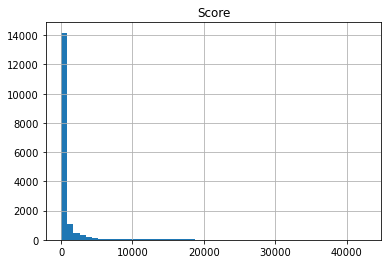

In [56]:
aita['score'].hist(bins=50);
plt.title('Score')

Text(0.5, 1.0, 'Number of Comments')

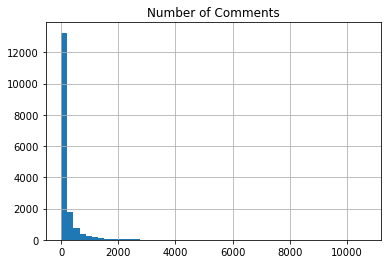

In [57]:
aita['num_comments'].hist(bins=50);
plt.title('Number of Comments')

### Who was the biggest asshole?

In [58]:
aita_big = aita.sort_values(by='score',ascending=False)
aita_big = aita_big[aita_big['link_flair_text']=='Asshole']
aita_big['author'].iloc[0]

'aljsdhnrthrow'

In [59]:
aita_big['selftext'].iloc[0]

'\nThrowaway because husband told me I was TA and want to know before I get home and argue. On phone format is bad.\n\nI was in a higher end department store today (rhymes with loomingtales) and happened to end up next to two teenage aged girls while shopping. One of the girls had picked out a pair of VERY expensive boots and they were both fawning over them. Second girl must have looked at price tag and asks boots girl if she’s really gonna spend that much on boots. Girl with boots says something along the lines of “it’s fine I have my dads credit card I’m not paying ” which instantly caught my attention because THATS NOT HER CARD. I’ve told my son multiple times he’s never allowed to use my card so I’m interested to see how this girl thinks she’s going to get away with fraud but had split up from the girls at this point because they had found something else.\n\nWe end up at the same register (me behind) and I see her total hit well over four digits. The girl is about to swipe her car

In [60]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemmas)

In [61]:
aita['proc_title'] = [x.lower() for x in aita['title']]
aita['proc_title'] = [s.translate(string.punctuation) for s in aita['proc_title']]

In [62]:
aita['proc_title'] = [preprocess(x) for x in aita['title']]
aita['proc_text'] = [preprocess(x) for x in aita['selftext']]

aita['proc_title'] = [x.replace('aita', '') for x in aita['proc_title']]
aita['proc_title'] = [x.replace('wibta', '') for x in aita['proc_title']]
# x200b
aita['proc_text'] = [x.replace('aita', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('wibta', '') for x in aita['proc_text']]
aita['proc_title'] = [x.replace('asshole', '') for x in aita['proc_title']]
aita['proc_text'] = [x.replace('asshole', '') for x in aita['proc_text']]

In [ ]:
# nltk.download('wordnet')

In [ ]:
aita.sort_values('num_comments', ascending = False, inplace = True)

In [ ]:
aita['link_flair_text'].value_counts()

In [ ]:
asshole_text = " ".join(aita.loc[(aita['label_id'] == 0)]['proc_text'])
nta_text = " ".join(aita.loc[(aita['label_id'] == 1)]['proc_text'])
na_text = " ".join(aita.loc[(aita['label_id'] == 2)]['proc_text'])
es_text = " ".join(aita.loc[(aita['label_id'] == 3)]['proc_text'])

In [ ]:
wordcloud = WordCloud( background_color="white").generate(asshole_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Asshole Wordcloud')
plt.show()

In [ ]:
wordcloud = WordCloud( background_color="white").generate(nta_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Not The Asshole Wordcloud')
plt.show()

In [ ]:
aita.describe()

In [ ]:
len(aita)

In [ ]:
aita['link_flair_text'].value_counts()

#### Terms
Score: the number of upvotes minus the number of downvotes.